<a href="https://colab.research.google.com/github/babuqu/studay/blob/gh-pages/test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
 

!pip install tensorflow-hub
!pip install tfds-nightly
#Tensorflow-hub 是 google 提供的机器学习模组打包函式库，
#帮开发者把TensorFlow的训练模型发布成模组，方便再次使用或是与社交共享
import tensorflow_hub as hub
#谷歌提供的数据集的包
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


在tensorflow数据集中获取IMDB数据集

In [11]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
#这也太方便了，少了数据处理部分
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [13]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch#取十条数据打印出来
train_labels_batch#取十条标签打印出来

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

让我们首先创建一个使用 Tensorflow Hub 模型嵌入（embed）语句的Keras层，并在几个输入样本中进行尝试

In [14]:
embedding = "https://hub.tensorflow.google.cn/google/nnlm-en-dim50/2"#预训练文本嵌入向量模型
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [ ]:
#搭建模型，并打印模型规格

第一层是 TensorFlow Hub 层。此层使用预训练的 SaveModel 将句子映射到其嵌入向量。您使用的预训练文本嵌入向量模型 (google/nnlm-en-dim50/2) 可将句子拆分为词例，嵌入每个词例，然后组合嵌入向量。生成的维度是：(num_examples, embedding_dimension)。对于此 NNLM 模型，embedding_dimension 是 50。

In [15]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


一个模型需要一个损失函数和一个优化器来训练。由于这是一个二元分类问题，并且模型输出 logit（具有线性激活的单一单元层），因此，我们将使用 binary_crossentropy 损失函数。

这并非损失函数的唯一选择，例如，您还可以选择 mean_squared_error。但是，一般来说，binary_crossentropy 更适合处理概率问题，它可以测量概率分布之间的“距离”，或者在我们的用例中，是指真实分布与预测值之间的差距。

稍后，当您探索回归问题（例如，预测房屋价格）时，您将看到如何使用另一个称为均方误差的损失函数。

现在，配置模型来使用优化器和损失函数：

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#训练模型
history = model.fit(train_data.shuffle(10000).batch(512),#10,000 个样本上采样 512 个样本的 mini-batch
                    
                    epochs=10,#十次
                    validation_data=validation_data.batch(512),
                    verbose=1)

In [18]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 5s - loss: 0.3572 - accuracy: 0.8539
loss: 0.357
accuracy: 0.854


#训练结果可视化

r 红
g 绿
b 蓝
c 蓝绿
m 紫红
y 黄
k 黑
w 白

o表示圆形
d表示菱形

In [19]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

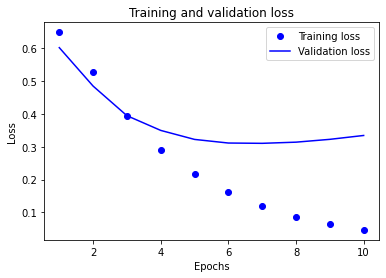

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')#x轴，y轴，颜色，标签
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')#x轴标签
plt.ylabel('Loss')#y轴标签
plt.legend()

plt.show()

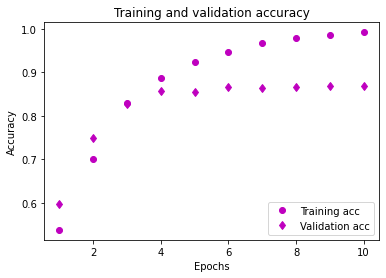

In [31]:
plt.plot(epochs, acc, 'mo', label='Training acc')
plt.plot(epochs, val_acc, 'md', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()